# Example 3: Search engines and PSM filtering

In this example we are going to parse the output of several search engines and see what we can do with it using **pyteomics**. We are going to need all of the extra dependencies of **pyteomics**: **lxml**, **numpy**, **matplotlib** and **pandas**.

The files used in this example can be downloaded from http://pubdata.theorchromo.ru/pyteomics_filtering_example/. The directory contains output files from several search engines: X!Tandem, MS Amanda, Morpheus, MS-GF+. All search engines were fed the same spectra. The results do not serve for performance comparison of these search engines, but for illustration of data handling with **pyteomics**.

Let's start with setting up the imports:

In [1]:
%pylab --no-import-all inline
from pyteomics import tandem, pepxml, mzid, auxiliary as aux, pylab_aux as pa
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Now, let's read an X!Tandem file using `tandem.read()` and build a histogram of retention times for identified spectra. Then, let's do the same for spectra passing the 1% FDR threshold, by using `tandem.filter()`.

CPU times: user 38.1 s, sys: 53.3 ms, total: 38.2 s
Wall time: 38.5 s


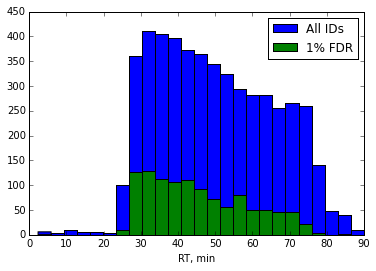

In [2]:
with tandem.read('example.t.xml') as tf:
    h = pylab.hist([psm['rt'] / 60 for psm in tf], bins=25, label='All IDs')
with tandem.filter('example.t.xml', fdr=0.01, full_output=False) as ftf:
    pylab.hist([psm['rt'] / 60 for psm in ftf], bins=h[1], label='1% FDR')
pylab.xlabel('RT, min')
pylab.legend()

The `filter()` functions can be used in the same way as `read()` functions (as a context manager). That is done by specifying `full_output=False`. The benefit of this is lower memory usage when parsing XML files. The downside, however, is that parsing occurs twice, affecting the execution time. That's why the default behavior of `filter()` is simply to return an array of PSMs:

In [56]:
%%time
ftf = tandem.filter('example.t.xml', fdr=0.01)
rts = [psm['rt'] / 60 for psm in ftf]

CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s


In [59]:
%%time
with tandem.filter('example.t.xml', fdr=0.01, full_output=False) as ftf:
   rts = [psm['rt'] / 60 for psm in ftf]

CPU times: user 23.5 s, sys: 20 ms, total: 23.5 s
Wall time: 23.5 s


In [58]:
%%time
ftf = tandem.filter_df('example.t.xml', fdr=0.01)
rts = ftf['rt']

CPU times: user 14.5 s, sys: 13.3 ms, total: 14.5 s
Wall time: 14.5 s


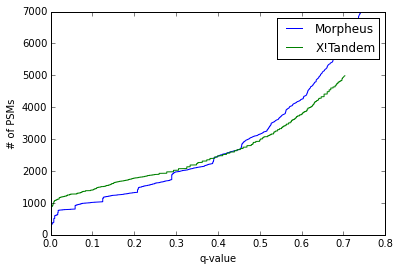

In [4]:
q1 = pepxml.qvalues('example.pep.xml', read_schema=False,
                    key=lambda x: x['search_hit'][0]['search_score']['Morpheus Score'], reverse=True)
q2 = tandem.qvalues('example.t.xml')

pa.plot_qvalue_curve(q1['q'], label='Morpheus')
pa.plot_qvalue_curve(q2['q'], label='X!Tandem')
pylab.legend()

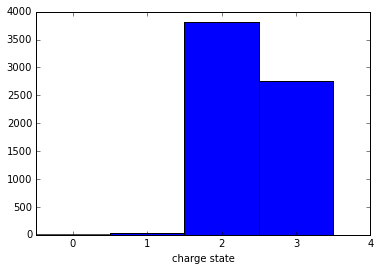

In [5]:
msgf = mzid.filter('example.mzid', retrieve_refs=True,
                   key=lambda x: x['SpectrumIdentificationItem'][0]['MS-GF:EValue'], fdr=0.01)
pylab.hist([psm['SpectrumIdentificationItem'][0]['chargeState'] for psm in msgf], bins=np.arange(5), align='left')
pylab.xticks(np.linspace(0, 4, 5))
pylab.xlabel('charge state')

In [6]:
morpheus = pd.read_table('example.PSMs.tsv')
amanda = pd.read_table('example_output.csv', skiprows=1)

In [7]:
morph_filt = aux.filter(morpheus, fdr=0.01, key='Morpheus Score', reverse=True,
                       is_decoy='Decoy?')

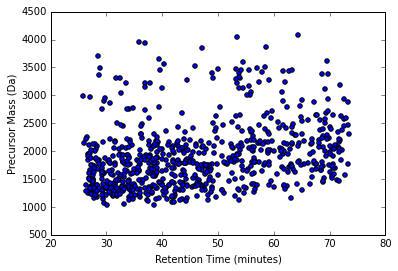

In [8]:
morph_filt.plot(x='Retention Time (minutes)' , y='Precursor Mass (Da)', kind='scatter')

In [9]:
amanda['isDecoy'] = [all(s.startswith('DECOY') for s in prot.split(';')) for prot in amanda['Protein Accessions']]
amanda_filt = aux.filter(amanda[amanda['Rank'] == 1], key='Weighted Probability', is_decoy='isDecoy', fdr=0.01)

In [32]:
amanda_pep = amanda_filt.sort('Weighted Probability').groupby('Sequence').first()
morph_pep = morph_filt.sort('Q-Value (%)').groupby('Base Peptide Sequence').first()

In [33]:
inter = amanda_pep.join(morph_pep, how='inner', lsuffix='[amanda]', rsuffix='[morpheus]')

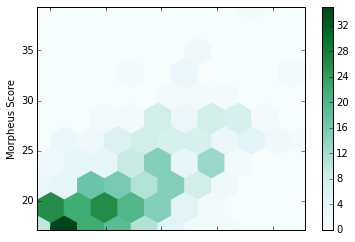

In [83]:
inter.plot('Amanda Score', 'Morpheus Score', kind='hexbin', gridsize=10)